# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
#!pip install wordcloud
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
import regex as re
import glob
#!pip install --upgrade pip
!pip install --upgrade Pillow
#!pip install freetype-py

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halledavis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = set(nltk.corpus.stopwords.words('english'))

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    counter = Counter()
    tokens.map(counter.update)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    num_tokens = sum(freq_df['freq'])
    num_unique_tokens = freq_df.shape[0]
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum((counter_df['index'].str.len()) * counter_df[0])

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print(f"The top 5 most common words are")
        print(counter.most_common(5))

    return(0)


    
def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return(len(emojis) > 0)


def remove_stop(tokens) :
    return [t for t in tokens if t.lower() not in stopwords]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text):
    return re.findall(r'\S+', text)

""" Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
os.getcwd()

'/Users/halledavis/Desktop'

In [5]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

#data_location = os.getcwd()
#twitter_folder = "twitter\"
#lyrics_folder = "lyrics\"


artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [6]:
path = "/Users/halledavis/Desktop/twitter/"
os.chdir(path)

twitter_data = pd.read_csv(artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [7]:
twitter_data_2 = pd.read_csv(artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [8]:
# read in the lyrics here

path = "/Users/halledavis/Desktop/lyrics/"
os.chdir(path)

file_list = glob.glob(os.path.join(os.getcwd(), "lilwayne", "*.txt"))

lilwaynelyrics = []

for file_path in file_list:
    with open(file_path) as f_input:
        lyrics = (f_input.read())
        file_name = file_path.split("/")[-1]
        lilwaynelyrics.append(
            {
                'Artist': "Lil Wayne",
                'Song': file_name,
                'lyrics': lyrics
            }
        )
        
lilwaynelyrics = pd.DataFrame(lilwaynelyrics)

In [9]:
file_list = glob.glob(os.path.join(os.getcwd(), "lildicky", "*.txt"))

lildickylyrics = []

for file_path in file_list:
    with open(file_path) as f_input:
        lyrics = (f_input.read())
        file_name = file_path.split("/")[-1]
        lildickylyrics.append(
            {
                'Artist': "Lil Dicky",
                'Song': file_name,
                'lyrics': lyrics
            }
        )
        
lildickylyrics = pd.DataFrame(lildickylyrics)

In [10]:
lyrics = [lilwaynelyrics, lildickylyrics]
lyrics_data = pd.concat(lyrics)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [11]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [12]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [13]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
306087,robyn,a raw subject 🐚 trabalho com conceitos,"[raw, subject, 🐚, trabalho, com, conceitos]"
1129597,cher,#INFJ 🏳️‍🌈 #NeverAgain #FBR,"[#infj, 🏳️‍🌈, #neveragain, #fbr]"
2248326,cher,Mitch is love and scott is life ✌️ but ptx are...,"[mitch, love, scott, life, ✌️, ptx, shiz, mitc..."
2029477,cher,#teamtrudeau Spiritual in Nature. advocate for...,"[#teamtrudeau, spiritual, nature, advocate, be..."
187451,cher,ACTOR OFFICIALS PAGE OF/❤LAV BAHADUR,"[actor, officials, page, of❤lav, bahadur]"
2489218,cher,Love Is Everthing And I Love My Family And Fri...,"[love, everthing, love, family, friends, take,..."
2053625,cher,"Armenian by birth, American by choice, Angelin...","[armenian, birth, american, choice, angelina, ..."
1169243,cher,#Whatever🤐😜😝Whatever,[#whatever🤐😜😝whatever]
1132899,cher,"I'm on the edge with yoü. Stick around, I prom...","[im, edge, yoü, stick, around, promise, i’m, f..."
267416,cher,Cabaret Maxime Tiller Gurl 💙💜🤍 #MembersOnly 👯‍♀️,"[cabaret, maxime, tiller, gurl, 💙💜🤍, #memberso..."


In [14]:
lilwaynelyrics["tokens"] = lilwaynelyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
lilwaynelyrics["num_tokens"] = lilwaynelyrics["tokens"].map(len) 

lildickylyrics["tokens"] = lildickylyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
lildickylyrics["num_tokens"] = lildickylyrics["tokens"].map(len) 

With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I notice a lot of people don't put a space between their emojis and their text. Our tokenizaiton only splits based on whitespace, making a lot of the tokens a word and an emoji in a singular string. I would split based on emoji and not emoji.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [15]:
# your code here

print("Lil Wayne Stats")
descriptive_stats(lilwaynelyrics["tokens"])
print("\n Lil Dicky Stats Stats")
descriptive_stats(lildickylyrics["tokens"])

Lil Wayne Stats
There are 9042 tokens in the data.
There are 1974 unique tokens in the data.
There are 41938 characters in the data.
The lexical diversity is 0.218 in the data.
The top 5 most common words are
[('nigga', 261), ('im', 201), ('like', 149), ('hot', 138), ('get', 113)]

 Lil Dicky Stats Stats
There are 8076 tokens in the data.
There are 2651 unique tokens in the data.
There are 38944 characters in the data.
The lexical diversity is 0.328 in the data.
The top 5 most common words are
[('im', 284), ('like', 166), ('dicky', 92), ('shit', 89), ('aint', 78)]


0

Q: What observations do you make about these data? 

A: In terms of length, Lil Wayne has a higher number of total tokens than Lil Dicky. Because I used the same number of songs from each artists, to me that implies that Lil Wayne songs are longer (in terms of lyrical length). The same can be said of the fact that Lil Wayne's corpus has more characters. However, Lil Dicky's lyrical diversity is higher.

I noticed that the top 5 most common words are different than they are last week. I think an issue is that we removed punctuation prior to removing stop words so "im" was not removed.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [52]:
lwtokens = lilwaynelyrics["tokens"]
counter = Counter()
lwtokens.map(counter.update)
lw_freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
lw_counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
#lw_counter_df["artist"] = "Lil Wayne"
#lw_counter_df

In [53]:
ldtokens = lildickylyrics["tokens"]
counter = Counter()
ldtokens.map(counter.update)
ld_freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
ld_counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
#ld_counter_df["artist"] = "Lil Dicky"
#ld_counter_df

In [54]:
lw_counter_df_filtered = lw_counter_df[lw_counter_df[0] > 5]
#lw_counter_df_filtered

In [55]:
ld_counter_df_filtered = ld_counter_df[ld_counter_df[0] > 5]
#ld_counter_df_filtered

In [56]:
lw_counter_df_filtered = lw_counter_df_filtered.rename(columns={0: "LilWayneCount"})
lw_counter_df_filtered = lw_counter_df_filtered.rename(columns={"index": "Token"})
#lw_counter_df_filtered

In [57]:
ld_counter_df_filtered = ld_counter_df_filtered.rename(columns={0: "LilDickyCount"})
ld_counter_df_filtered = ld_counter_df_filtered.rename(columns={"index": "Token"})
#ld_counter_df_filtered

In [58]:
commoncounter = pd.merge(lw_counter_df_filtered, ld_counter_df_filtered, on ='Token')
commoncounter

,Token,LilWayneCount,LilDickyCount
0,come,96,10
1,play,26,10
2,time,48,12
3,better,45,17
4,cause,66,69
...,...,...,...
111,good,9,21
112,whats,6,6
113,club,9,17
114,fuckin,8,53


In [59]:
LilWayneTokens = 9042
LilDickyTokens = 8076

# from descriptive statistic output

In [66]:
commoncounter["Concentration1"] = (commoncounter["LilWayneCount"]/LilWayneTokens)*100
commoncounter["Concentration2"] = (commoncounter["LilDickyCount"]/LilDickyTokens)*100
commoncounter["Ratio"] = commoncounter["Concentration1"]/commoncounter["Concentration2"]

In [65]:
commoncounter.sort_values('Ratio',ascending = False).head(10)

,Token,LilWayneCount,LilDickyCount,Concentration1,Concentration2,Ratio
93,hot,138,9,1.526211,0.111441,13.695200
0,come,96,10,1.061712,0.123824,8.574386
51,keep,42,6,0.464499,0.074294,6.252157
11,let,38,6,0.420261,0.074294,5.656713
2,time,48,12,0.530856,0.148588,3.572661
58,still,31,8,0.342845,0.099059,3.461015
22,thats,62,17,0.685689,0.210500,3.257426
12,em,86,24,0.951117,0.297177,3.200509
45,look,52,15,0.575094,0.185736,3.096306
47,head,24,7,0.265428,0.086677,3.062281


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: A lot of these words seem very generic, but I'm seeing a lot of verbs/call to action words, like "come" "keep" "let" and "look". I think of Lil Dicky as more of a story teller so it would make sense that he would have less calls to action/commands.

In addition, I think the word "em" is interesting -- it demonstrates the informality of Lil Wayne vs. Lil Dicky, despite the fact that they're both rap artists.

Finally, I notice that all words are used more by Lil Wayne than Lil Dicky: again, I think Lil Wayne has a super low level of lexical diversity, so it's very difficult to use a certain word more than him: if he uses a word, he uses it a lot. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [17]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [18]:
lilwayne_word_freq = count_words(lilwaynelyrics)
lildicky_word_freq = count_words(lildickylyrics)

In [19]:
lilwayne_word_freq = lilwayne_word_freq.squeeze()
lildicky_word_freq = lildicky_word_freq.squeeze()

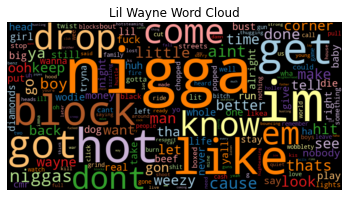

In [20]:
wordcloud(lilwayne_word_freq, "Lil Wayne Word Cloud")

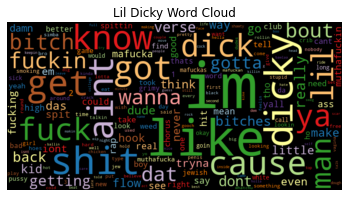

In [21]:
wordcloud(lildicky_word_freq, "Lil Dicky Word Cloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: I see the same top 5 most common words that were in the output of the descriptive statistics function. One really interesting thing to me is that Lil Dicky has higher lexical diversity than Lil Wayne, and that's visualized in the word cloud: he has very words that are huge/super commonly used; whereas, Lil Wayne has a lot of big words, meaning he uses the same words over and over.